# Library

In [1]:
# !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
# !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
# !pip install -q torch-geometric

In [2]:
#Pytorch library
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch_geometric.utils as pyg_utils
import torch_geometric.transforms as T
from torch_geometric.data import Data, DataLoader

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#np.set_printoptions(precision=3, threshold=9, edgeitems=4, suppress=True)
#torch.set_printoptions(precision=3, threshold=9, edgeitems=4, sci_mode=False)
np.set_printoptions(precision=3, suppress=True)
torch.set_printoptions(precision=3, sci_mode=False)

# Data preprocessing library

In [3]:
def normalize_dataset(x, y):
  x_mean = torch.mean(x)
  y_mean = torch.mean(y)
  x_std = torch.std(x)
  y_std = torch.std(y)
  x = (x-torch.mean(x))/torch.std(x)
  y = (y-torch.mean(y))/torch.std(y)
  x = torch.where(torch.isnan(x), torch.zeros_like(x), x)
  y = torch.where(torch.isnan(y), torch.zeros_like(y), y)
  return x, y, x_mean, y_mean, x_std, y_std

def normalize_input(x, x_mean, x_std):
  return (x-x_mean)/x_std

def denormalize_output(y, y_mean, y_std):
  return y*y_std+y_mean

def slice_dataset(x_dataset, y_dataset, n_train_percent):
  data_size = len(x_dataset)
  x_train = x_dataset[:int(data_size*n_train_percent)]
  x_test = x_dataset[int(data_size*n_train_percent):]
  y_train = y_dataset[:int(data_size*n_train_percent)]
  y_test = y_dataset[int(data_size*n_train_percent):]
  return x_train, y_train, x_test, y_test

# power flow dataset

In [4]:
df = pd.read_excel('gnn_dataset.xlsx')
df.head

<bound method NDFrame.head of    PF Dataset  Bus1_Pgen  Bus1_Qgen  Bus1_Vgen  Bus1_dgen  Bus2_Pgen  \
0      Data 1    252.130     57.136      9.907          0      163.0   
1      Data 2    265.068     50.663      9.907          0      163.0   
2      Data 3    127.246     15.918      9.907          0      163.0   
3      Data 4    384.471    110.843      9.907          0      163.0   
4      Data 5    283.846     70.385      9.907          0      163.0   
..        ...        ...        ...        ...        ...        ...   
95    Data 96    260.495     69.772      9.907          0      163.0   
96    Data 97    154.545     26.128      9.907          0      163.0   
97    Data 98    238.472     60.046      9.907          0      163.0   
98    Data 99    288.899     71.200      9.907          0      163.0   
99   Data 100    226.043     55.963      9.907          0      163.0   

    Bus2_Qgen  Bus2_Vgen  Bus2_dgen  Bus3_Pgen  ...  Bus7_Vload  Bus7_dload  \
0      29.579     10.652  

In [5]:
n_node = 9
dataset_length = len(df.index)

data_x, data_y = [], []
x_raw, y_raw = [], []
for row in range(dataset_length):
  for col in range(n_node):
    if col == 0:
      data_x.append(list([df.iloc[row, 3], df.iloc[row, 4]]))
      data_y.append(list([df.iloc[row, 1], df.iloc[row, 2]]))
    elif col == 1 or col == 2:
      data_x.append(list([df.iloc[row, col*4+1], df.iloc[row, col*4+3]]))
      data_y.append(list([df.iloc[row, col*4+2], df.iloc[row, col*4+4]]))
    else:
      data_x.append(list([df.iloc[row, col*4+1], df.iloc[row, col*4+2]]))
      data_y.append(list([df.iloc[row, col*4+3], df.iloc[row, col*4+4]]))
  x_raw.append(list(data_x))
  y_raw.append(list(data_y))
  data_x, data_y = [], []

x_raw = torch.tensor(x_raw, dtype=torch.float)
y_raw = torch.tensor(y_raw, dtype=torch.float)

In [6]:
n_train_percent = 0.5

x_raw_train, y_raw_train, x_raw_test, y_raw_test = slice_dataset(x_raw, y_raw, n_train_percent)
x, y, x_mean, y_mean, x_std, y_std = normalize_dataset(x_raw, y_raw)
x_train, y_train, x_test, y_test = slice_dataset(x, y, n_train_percent)

In [7]:
x_train, y_train = x_train, y_train #x_raw_train, y_raw_train
x_test, y_test = x_test, y_test #x_raw_test, y_raw_test
edge_index = torch.tensor([[0, 3, 3, 4, 3, 5, 4, 6, 5, 8, 1, 6, 6, 7, 7, 8, 2, 8], [3, 0, 4, 3, 5, 3, 6, 4, 8, 5, 6, 1, 7, 6, 8, 7, 8, 2]], dtype=torch.long) #to form adjacency matrix

data_train_list, data_test_list = [], []
for i,_ in enumerate(x_train):
  data_train_list.append(Data(x=x_train[i], y=y_train[i], edge_index=edge_index))
for i,_ in enumerate(x_raw_test):
  data_test_list.append(Data(x=x_test[i], y=y_test[i], edge_index=edge_index))

train_loader = DataLoader(data_train_list, batch_size=100)
test_loader = DataLoader(data_test_list, batch_size=100)

# GCN

In [8]:
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = GCNConv(2, 32)
    self.conv2 = GCNConv(32, 16)
    self.conv3 = GCNConv(16, 2)

  def forward(self, data):
    x, edge_index = data.x, data.edge_index

    x = self.conv1(x, edge_index)
    x = torch.tanh(x)

    x = self.conv2(x, edge_index)
    x = torch.tanh(x)

    x = self.conv3(x, edge_index)

    return x

In [9]:
%%time
#without sparse matrix, batching one by one for 100 data spends 38 minutes
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_loss_list, test_loss_list = [], []

for epoch in range(3001):

  model.train()
  train_loss = 0
  for batch in train_loader:
    optimizer.zero_grad()
    pred = model(batch)
    loss = F.mse_loss(denormalize_output(pred, y_mean, y_std), denormalize_output(batch.y, y_mean, y_std))
    loss.backward()
    optimizer.step()
    train_loss += loss.item() * batch.num_graphs
  train_loss /= len(train_loader.dataset)
  train_loss_list.append(train_loss)

  model.eval()
  test_loss=0
  for batch in test_loader:
    pred = model(batch)
    loss = F.mse_loss(denormalize_output(pred, y_mean, y_std), denormalize_output(batch.y, y_mean, y_std))
    test_loss += loss.item() * batch.num_graphs
  test_loss /= len(test_loader.dataset)
  test_loss_list.append(test_loss)

  if (epoch % 300) == 0:
    print('Epoch: {:04d}, train loss: {:5.3f}, test loss: {:5.3f}'.
    format(epoch, train_loss, test_loss))

Epoch: 0000, train loss: 4267.658, test loss: 3741.873
Epoch: 0300, train loss: 1890.071, test loss: 1890.385
Epoch: 0600, train loss: 1270.097, test loss: 1270.496
Epoch: 0900, train loss: 968.821, test loss: 984.469
Epoch: 1200, train loss: 814.750, test loss: 849.691
Epoch: 1500, train loss: 761.363, test loss: 826.864
Epoch: 1800, train loss: 652.554, test loss: 724.843
Epoch: 2100, train loss: 687.222, test loss: 725.575
Epoch: 2400, train loss: 614.714, test loss: 685.915
Epoch: 2700, train loss: 524.441, test loss: 644.569
Epoch: 3000, train loss: 486.259, test loss: 619.894
Wall time: 54.5 s


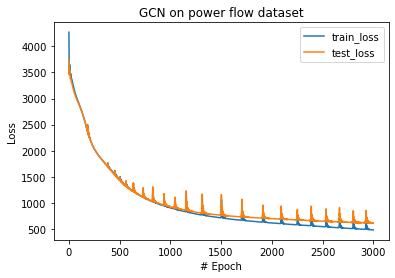

epoch: 3000, train loss: 486.25937, test loss: 619.89380


In [10]:
plt.title('GCN on power flow dataset')
plt.plot(train_loss_list, label="train_loss")
plt.plot(test_loss_list, label="test_loss")
plt.xlabel("# Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

print('epoch: {:03d}, train loss: {:.5f}, test loss: {:.5f}'.
          format(epoch, train_loss, test_loss))

In [11]:
model.eval()

y_train_prediction = model(data_train_list[0])
train_loss_1 = F.mse_loss(denormalize_output(y_train_prediction, y_mean, y_std), denormalize_output(data_train_list[0].y, y_mean, y_std))
print("Train output: \n" + str(denormalize_output(data_train_list[0].y, y_mean, y_std).detach().numpy()))
print()
print("Train output prediction: \n" + str(denormalize_output(y_train_prediction, y_mean, y_std).detach().numpy()))
print('Train loss (MSE): {:.5f}'.format(train_loss_1))
print()
print("======================")
print()
y_test_prediction = model(data_test_list[-1])
test_loss_1 = F.mse_loss(denormalize_output(y_test_prediction, y_mean, y_std), denormalize_output(data_test_list[-1].y, y_mean, y_std))
print("Test output: \n" + str(denormalize_output(data_test_list[-1].y, y_mean, y_std).detach().numpy()))
print()
print("Test output prediction: \n" + str(denormalize_output(y_test_prediction, y_mean, y_std).detach().numpy()))
print('Test loss (MSE): {:.5f}'.format(test_loss_1))

Train output: 
[[252.13   57.136]
 [ 29.579  -4.824]
 [ 31.966 -12.65 ]
 [135.178 142.116]
 [134.258 139.763]
 [132.894 135.852]
 [134.365 139.539]
 [132.437 135.263]
 [133.839 134.587]]

Train output prediction: 
[[247.007  55.756]
 [ 60.922  -5.203]
 [ 69.259  -3.322]
 [176.041 150.565]
 [151.208 142.388]
 [118.765 124.006]
 [115.986 126.319]
 [144.49  132.224]
 [ 99.666 117.317]]
Train loss (MSE): 388.71643


Test output: 
[[226.043  55.963]
 [ 61.89   -4.06 ]
 [ 49.702  -7.021]
 [135.014 142.927]
 [134.027 139.523]
 [130.995 138.661]
 [131.762 140.192]
 [130.299 138.681]
 [132.494 140.188]]

Test output prediction: 
[[246.695  61.085]
 [ 73.557  -5.304]
 [ 51.673 -14.08 ]
 [165.692 149.31 ]
 [113.044 131.985]
 [131.572 133.108]
 [102.375 130.832]
 [123.003 131.946]
 [114.344 130.403]]
Test loss (MSE): 201.62250
